In [ ]:
import numpy as np
import pandas as pd
columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "level"]
attack_type = {
    0: 'normal',
    1: 'DOS',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R'
}

new_label = {
    'normal': 0,
    'apache2': 1,
    'back': 1,
    'mailbomb': 1,
    'processtable': 1,
    'snmpgetattack': 1,
    'teardrop': 1,
    'smurf': 1,
    'land': 1,
    'neptune': 1,
    'pod': 1,
    'udpstorm': 1,
    'nmap': 2,
    'ipsweep': 2,
    'portsweep': 2,
    'satan': 2,
    'mscan': 2,
    'saint': 2,
    'ftp_write': 3,
    'guess_passwd': 3,
    'snmpguess': 3,
    'imap': 3,
    'spy': 3,
    'warezclient': 3,
    'warezmaster': 3,
    'multihop': 3,
    'phf': 3,
    'imap': 3,
    'named': 3,
    'sendmail': 3,
    'xlock': 3,
    'xsnoop': 3,
    'worm': 3,
    'ps': 4,
    'buffer_overflow': 4,
    'perl': 4,
    'rootkit': 4,
    'loadmodule': 4,
    'xterm': 4,
    'sqlattack': 4,
    'httptunnel': 4
}

# Preprocessing dataset

Drop na and duplicates

In [ ]:
train = pd.read_csv("NSL-KDD/KDDTrain+.txt", header=None)
train.columns = columns
train = train.dropna()
train = train.drop_duplicates()
test = pd.read_csv("NSL-KDD/KDDTest+.txt", header=None)
test.columns = columns
test = test.dropna()
test = test.drop_duplicates()

In [ ]:
last_index_train = train.index.to_list()[-1]
df = pd.concat([train, test])

In [ ]:
df.shape

OneHotEncoder at `protocol_type`, `service` and `flag` 

In [ ]:
df.dtypes

In [ ]:
from preprocessing import encode_text_dummy
encode_text_dummy(df=df, name="protocol_type")
encode_text_dummy(df=df, name="service")
encode_text_dummy(df=df, name="flag")

In [ ]:
df

Split to train and test set

In [ ]:
train = df.iloc[:last_index_train+1]
test = df.iloc[last_index_train+1:]
X_train = train.drop(columns=['label', 'level'])
y_train = train.label.map(new_label).map(attack_type)
X_test = test.drop(columns=['label', 'level'])
y_test = test.label.map(new_label).map(attack_type)

Normalize trainset/testset

In [ ]:
from sklearn.preprocessing import MinMaxScaler
features = X_train.columns
scalser = MinMaxScaler()
scalser.fit(X_train)
X_train = scalser.transform(X_train)
X_test = scalser.transform(X_test)

SMOTE for balance dataset

In [ ]:
y_train.value_counts()

In [ ]:
from imblearn.over_sampling import SMOTE

desired_samples = {
    "U2R": 5000,
    "R2L": 5000
}

bal = SMOTE(sampling_strategy=desired_samples)

X_train, y_train = bal.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

# DEEP NEURAL MODEL

In [ ]:
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])
encode_text_dummy(y_train, 'label')
encode_text_dummy(y_test, 'label')

In [ ]:
X_train.to_csv("NSL-KDD/X_train.csv")
y_train.to_csv("NSL-KDD/y_train.csv")
X_test.to_csv("NSL-KDD/X_test.csv")
y_test.to_csv("NSL-KDD/y_test.csv")

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
import tensorflow as tf
from art.estimators.tensorflow import TensorFlowV2Estimator

layers = [
    tf.keras.layers.Dense(X_train.shape[0], activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
]
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn = tf.keras.models.Sequential(layers=layers)
dnn.compile(
    loss=loss_object,
    optimizer=optimizer,
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ]
)
dnn.fit(
    x=X_train,
    y=y_train.values,
    epochs=5,
    batch_size=1024
)

In [ ]:
dnn.save("NSL-KDD/dnn.h5")

# SHAP and ART

load model, train and test set

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

dnn = tf.keras.models.load_model("NSL-KDD/dnn.h5")
X_train = pd.read_csv("NSL-KDD/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("NSL-KDD/y_train.csv").drop(columns=['Unnamed: 0'])
X_test = pd.read_csv("NSL-KDD/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("NSL-KDD/y_test.csv").drop(columns=['Unnamed: 0'])

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn_model = TensorFlowV2Classifier(
    model=dnn,
    loss_object=loss_object,
    optimizer=optimizer,
    nb_classes=5,
    input_shape=X_train.shape
)

In [ ]:
from evaluation_metric import evaluate_metric
evaluate_metric(y_pred=dnn_model.predict(x=X_test), y_true=y_test.values)

In [ ]:
samples = X_test.sample(n=500)
y_samples = y_test.iloc[samples.index]

In [ ]:
from evaluation_metric import evaluate_metric
evaluate_metric(
    y_pred=dnn_model.predict(x=samples),
    y_true=y_samples
)

calculate shap values

In [ ]:
import shap
from shap_importance import shap_importance

background = pd.read_csv("NSL-KDD/samples/background.csv").drop(columns=["Unnamed: 0"])
samples = pd.read_csv("NSL-KDD/samples/samples.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/samples/y_samples.csv").drop(columns=["Unnamed: 0"])

explainer = shap.DeepExplainer(model=dnn, data=background.values)
shap_vals = explainer.shap_values(samples.values)

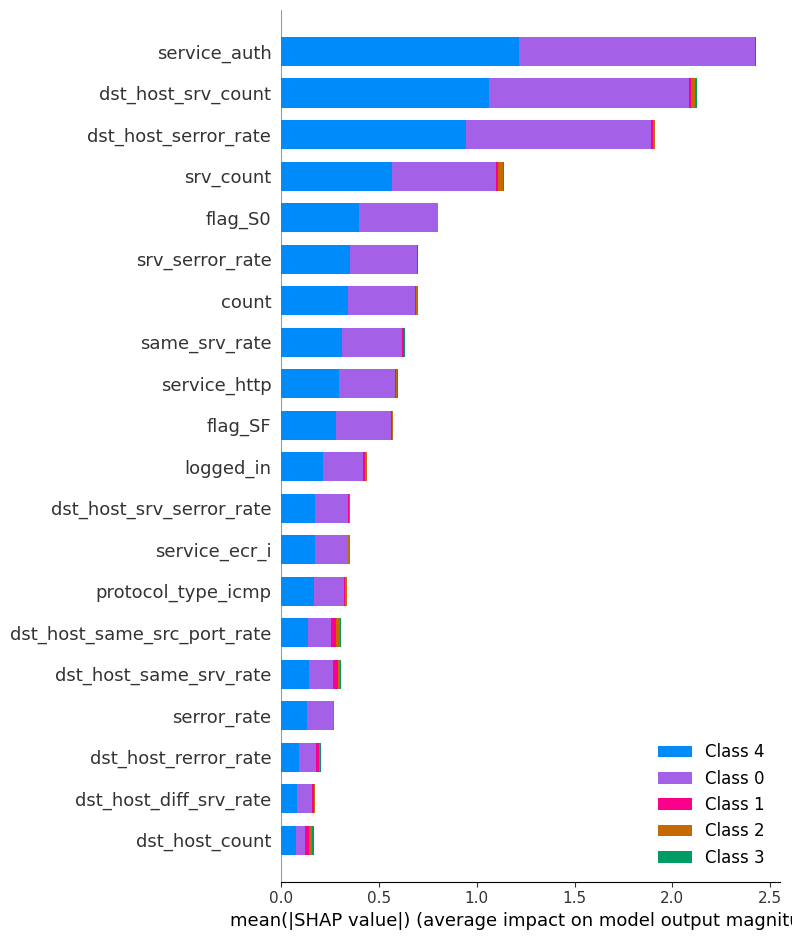

In [45]:
import shap
shap.summary_plot(shap_vals, samples.columns)

accuracy plot when increase number of adversarial features

In [1]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from adversarial_n_best_worst_features import adversarial_n_best_worst_features
from shap_importance import shap_importance
from art.attacks.evasion.fast_gradient import FastGradientMethod
from art.attacks.evasion.iterative_method import BasicIterativeMethod
from art.attacks.evasion.saliency_map import SaliencyMapMethod
from art.attacks.evasion.carlini import CarliniL0Method, CarliniLInfMethod ,CarliniL2Method
from art.attacks.evasion.deepfool import DeepFool
from art.estimators.classification import TensorFlowV2Classifier

dnn = tf.keras.models.load_model("NSL-KDD/dnn.h5")
X_train = pd.read_csv("NSL-KDD/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("NSL-KDD/y_train.csv").drop(columns=['Unnamed: 0'])
X_test = pd.read_csv("NSL-KDD/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("NSL-KDD/y_test.csv").drop(columns=['Unnamed: 0'])


loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn_model = TensorFlowV2Classifier(
    model=dnn,
    loss_object=loss_object,
    optimizer=optimizer,
    nb_classes=5,
    input_shape=X_train.shape
)


# background = pd.read_csv("NSL-KDD/samples/background.csv").drop(columns=["Unnamed: 0"])
samples = pd.read_csv("NSL-KDD/samples/samples.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/samples/y_samples.csv").drop(columns=["Unnamed: 0"])
shap_vals = pickle.load(open("NSL-KDD/samples/shap_vals_of_samples.pkl","rb"))
shap_vals = [np.array(val) for val in shap_vals]

adversarial_algs = {
    "FSGM": FastGradientMethod(estimator=dnn_model, eps=0.2),
    "BIM": BasicIterativeMethod(estimator=dnn_model, eps=0.2, max_iter=100, batch_size=32),
    "CW-L2": CarliniL2Method(classifier=dnn_model, max_iter=10),
    "JSMA": SaliencyMapMethod(classifier=dnn_model,theta=0.1,gamma=1, batch_size=1),
    "DeepFool": DeepFool(classifier=dnn_model, max_iter=100, epsilon=0.000001, nb_grads=10, batch_size=1),
}


In [34]:
full_features = samples.columns
shap_importance_df = shap_importance(full_features, shap_val_of_sample=shap_vals)
selected_features = [f for f in shap_importance_df.loc[shap_importance_df['shap_importance']!= 0]['column_name'].values]

Generate AE sample with popular algorithm

In [3]:
import pickle as plk
acc_list = []

for alg_name in adversarial_algs:
    print(f"{alg_name}")
    alg = adversarial_algs[alg_name]
    org_samples = samples.copy()
    adv_samples = alg.generate(x=org_samples.values) + np.random.uniform(0,10**-10, size=org_samples.shape)
    adv_samples = pd.DataFrame(adv_samples, columns=full_features)
    print(f"\t{alg_name} finish generate adversarial.")
    pd.DataFrame(np.clip(adv_samples,0,1), columns=full_features).to_csv(f"NSL-KDD/samples/attack/{alg_name}_sample.csv")

FSGM
	FSGM finish generate adversarial.
BIM


	BIM finish generate adversarial.
CW-L2


C&W L_2:   0%|          | 0/500 [00:00<?, ?it/s]

C&W L_2: 100%|██████████| 500/500 [7:53:53<00:00, 56.87s/it]  


	CW-L2 finish generate adversarial.
JSMA


JSMA: 100%|██████████| 500/500 [16:06<00:00,  1.93s/it]


	JSMA finish generate adversarial.
DeepFool


DeepFool:   0%|          | 0/500 [00:00<?, ?it/s]

DeepFool: 100%|██████████| 500/500 [32:28<00:00,  3.90s/it]  


	DeepFool finish generate adversarial.


Fast Gradient Method

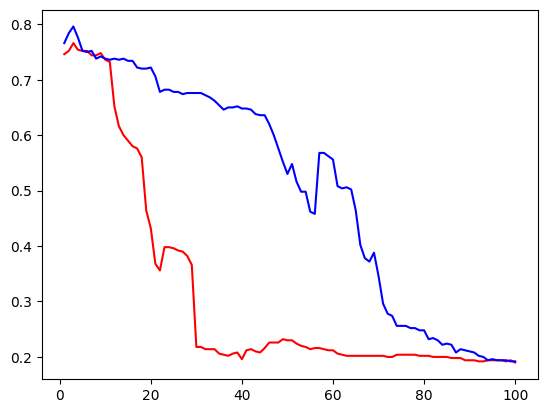

In [35]:
acc_on_fsgm = adversarial_n_best_worst_features(
    model=dnn_model,
    selected_features=selected_features,
    samples=samples,
    adv_samples=pd.read_csv("NSL-KDD/samples/attack/FSGM_sample.csv"),
    y_true=y_samples
)

import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_fsgm[0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_fsgm[1] , 'blue')

plt.show()

Basic Interactive Method

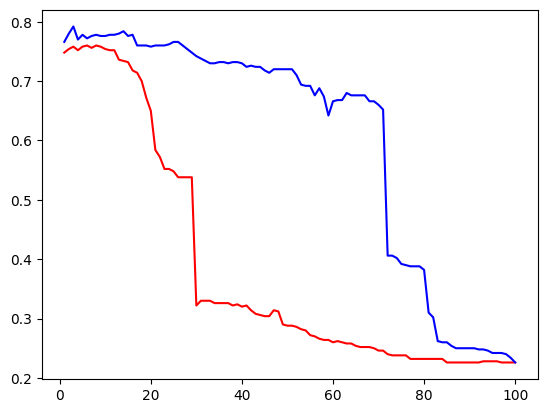

In [36]:
import matplotlib.pyplot as plt

acc_on_bim = adversarial_n_best_worst_features(
    model=dnn_model,
    selected_features=selected_features,
    samples=samples,
    adv_samples=pd.read_csv("NSL-KDD/samples/attack/BIM_sample.csv"),
    y_true=y_samples
)

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_bim[0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_bim[1] , 'blue')

plt.show()

Carlini L2 Method

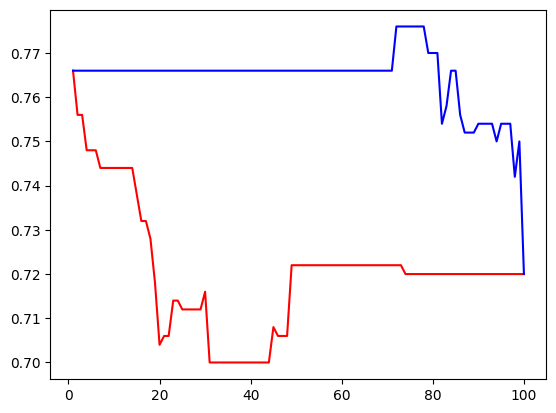

In [40]:
import matplotlib.pyplot as plt

acc_on_cwl2 = adversarial_n_best_worst_features(
    model=dnn_model,
    selected_features=selected_features,
    samples=samples,
    adv_samples=pd.read_csv("NSL-KDD/samples/attack/CW-L2_sample.csv"),
    y_true=y_samples
)

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_cwl2[0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_cwl2[1] , 'blue')

plt.show()

Saliency Map Method

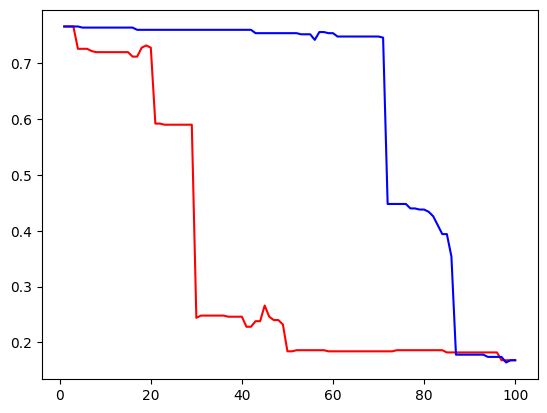

In [38]:
import matplotlib.pyplot as plt

acc_on_jsma = adversarial_n_best_worst_features(
    model=dnn_model,
    selected_features=selected_features,
    samples=samples,
    adv_samples=pd.read_csv("NSL-KDD/samples/attack/JSMA_sample.csv"),
    y_true=y_samples
)

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_jsma[0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_jsma[1] , 'blue')

plt.show()

DeepFool

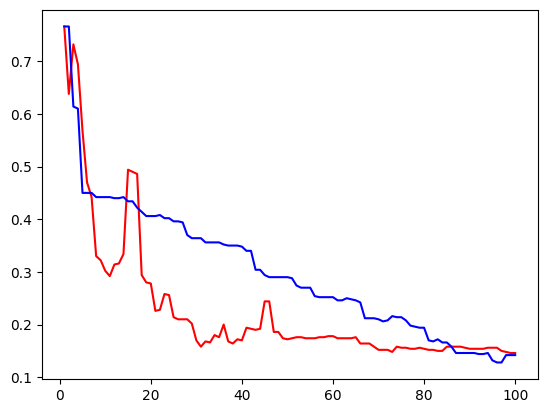

In [39]:
import matplotlib.pyplot as plt

acc_on_deepfool = adversarial_n_best_worst_features(
    model=dnn_model,
    selected_features=selected_features,
    samples=samples,
    adv_samples=pd.read_csv("NSL-KDD/samples/attack/DeepFool_sample.csv"),
    y_true=y_samples
)

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_deepfool[0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_on_deepfool[1] , 'blue')

plt.show()

# DEFENSE MECHANISM

In [263]:
import pandas as pd
import numpy as np

def generate_dataset(
    clean: pd.DataFrame,
    fsgm: pd.DataFrame,
    bim: pd.DataFrame,
    cw_l2: pd.DataFrame,
    jsma: pd.DataFrame,
    deepfool: pd.DataFrame,
    selected_features: list,
    shap_importance_feature_values: list,
    top_n_features: int = 10
):    
    n_selected_features = selected_features[:top_n_features]
    values = shap_importance_feature_values[:top_n_features]
    dfs = [
        clean[n_selected_features],
        fsgm[n_selected_features],
        bim[n_selected_features],
        cw_l2[n_selected_features],
        jsma[n_selected_features],
        deepfool[n_selected_features]
        ]
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    labels = [1 for _ in range(dfs.shape[0])]
    labels[:clean.shape[0]] = [0] * clean.shape[0]
    labels = pd.DataFrame(
        {"label":labels}
    )
    
    return pd.concat([dfs, labels], axis=1).sample(frac=1, ignore_index=True)

In [264]:
import pandas as pd
# from defense.generate_dataset import generate_dataset

samples = pd.read_csv("NSL-KDD/samples/samples.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/samples/y_samples.csv").drop(columns=["Unnamed: 0"])
fsgm_samples = pd.read_csv("NSL-KDD/samples/attack/FSGM_sample.csv").drop(columns=["Unnamed: 0"])
bim_samples = pd.read_csv("NSL-KDD/samples/attack/BIM_sample.csv").drop(columns=["Unnamed: 0"])
cwl2_samples = pd.read_csv("NSL-KDD/samples/attack/CW-L2_sample.csv").drop(columns=["Unnamed: 0"])
jsma_samples = pd.read_csv("NSL-KDD/samples/attack/JSMA_sample.csv").drop(columns=["Unnamed: 0"])
deepfool_samples = pd.read_csv("NSL-KDD/samples/attack/DeepFool_sample.csv").drop(columns=["Unnamed: 0"])
shap_importance_df = pd.read_csv("NSL-KDD/samples/shap_importance.csv").drop(columns=["Unnamed: 0"])
selected_features = shap_importance_df.loc[shap_importance_df['shap_importance'] > 0]['column_name'].values
shap_importance_feature_values = shap_importance_df.loc[shap_importance_df['shap_importance'] > 0]['shap_importance'].values

defense_data = generate_dataset(
    samples,
    fsgm_samples,
    bim_samples,
    cwl2_samples,
    jsma_samples,
    deepfool_samples,
    selected_features,
    shap_importance_feature_values,
    5
)

In [265]:
defense_data

,service_auth,dst_host_srv_count,dst_host_serror_rate,srv_count,flag_S0,label
0,0.000000e+00,4.000000,6.000000e-01,1.327593,2.000000e-01,1
1,4.093251e-04,3.828444,5.993577e-02,0.043996,0.000000e+00,1
2,2.553210e-10,4.000000,5.952701e-11,0.262622,8.267905e-11,1
3,1.062923e-10,1.223529,2.470253e-10,0.023483,5.005689e-11,1
4,5.000000e+00,4.000000,0.000000e+00,0.000000,0.000000e+00,1
...,...,...,...,...,...,...
2995,0.000000e+00,0.972549,0.000000e+00,0.000000,2.000000e-01,1
2996,4.839487e-10,0.015686,2.265775e-10,0.003914,3.508203e-11,1
2997,0.000000e+00,4.000000,0.000000e+00,0.035225,0.000000e+00,0
2998,0.000000e+00,4.000000,0.000000e+00,0.023483,0.000000e+00,0


In [266]:
from sklearn.model_selection import train_test_split
x_defense_train, x_defense_test, y_defense_train, y_defense_test = train_test_split(
    defense_data.drop(columns=['label']),
    defense_data['label'],
    test_size=0.3,
    stratify=defense_data['label']
)

In [267]:
y_defense_train.value_counts()

label
1    1750
0     350
Name: count, dtype: int64

In [268]:
from imblearn.over_sampling import SMOTE

balance_defense = SMOTE(sampling_strategy={0:1000})

x_defense_train, y_defense_train = balance_defense.fit_resample(x_defense_train, y_defense_train)

In [269]:
import tensorflow as tf
def create_dnn(n_features):
    ae_detector_dnn = tf.keras.Sequential(
        layers=[
            tf.keras.layers.Dense(100, activation='relu', input_shape=(n_features,)),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(1, activation='softmax'),
        ]
    )
    
    ae_detector_dnn.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    return ae_detector_dnn

In [270]:
ae_detector_dnn = create_dnn(x_defense_train.shape[1])
ae_detector_dnn.fit(x_defense_train, y_defense_train)

86/86 [==============================] - 1s 2ms/step - loss: 0.6168 - accuracy: 0.6364


In [271]:
ae_detector_dnn.evaluate(x_defense_train, y_defense_train)

86/86 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.6364


[0.5789514780044556, 0.6363636255264282]

In [272]:
ae_detector_dnn.evaluate(x_defense_test, y_defense_test)

29/29 [==============================] - 0s 2ms/step - loss: 0.4760 - accuracy: 0.8333


[0.476021945476532, 0.8333333134651184]